# Week 09

Unsupervised Learning: Distances, Clustering and PCA

## Setup

Run the following 2 cells to import all necessary libraries and helpers for this week's exercises

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/audio_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import Audio
from sklearn.model_selection import train_test_split

from audio_utils import fft, wav_to_list

from data_utils import PCA, RandomForestClassifier, StandardScaler
from data_utils import KMeansClustering, SpectralClustering
from data_utils import object_from_json_url, classification_error, display_confusion_matrix

from image_utils import make_image, open_image

## Cost and Distance Functions

The concept of **_distance_** is something that we saw and used in previous exercises but didn't talk too much about.

**_Distance_** is how we tell how close two data points are to each other, and is the basis for clustering, classification and regression algorithms.

In classification, we learn how to label new data based on how "close" it is to our already-labeled training data. In regression, we find parameters to equations that make our line-of-best-fit "close" to all of the points in the dataset. In clustering, we group data points in a way that minimizes distances between points within a cluster, while maximizing the distances between clusters. Distance is also an important concept for recommendation systems where we want to calculate when someone's taste is close to someone else's.

### 1D

The concept of distance in one dimension is pretty easy to understand: it's how far two points on a line are to each other. Physically, we can think of $1D$ distance as the distance between runners in a race, or, we can even think of time as a one-dimensional space where we measure distance between events in seconds, or minutes, or days.

<img src="./imgs/dist1d.jpg" height="220px" />

Each point in 1-dimensional space is described with a single variable, and the distance between any two points is just the absolute value of their difference:

$\displaystyle D(x_0, x_1) = |x_0 - x_1|$<br>
$\displaystyle D(x_0, x_2) = |x_0 - x_2|$

### 2D

Two-dimensional distances, where we have $2$ variables to describe each of our points, is also pretty familiar to us. This can be the distance between two cities on a map, measured in angles of longitude and latitude, or distances between two points in Manhattan, measured in streets and avenues.

<img src="./imgs/dist2d.jpg" width="95%" />

We have $2$ variables for each of our points and we also have $2$ ways in which we can combine them to measure distances in $2D$. The first is called $L1$, or Manhattan, distance, and it's the sum of the distances in each of the separate dimensions.

$\displaystyle D_{L1}(x_0y_0, x_1y_1) = |x_0 - x_1| + |y_0 - y_1|$

The other way of measuring distances in $2D$ is using the $L2$, or Euclidean, distance formula:

$\displaystyle D_{L2}(x_0y_0, x_2y_2) = \sqrt{(x_0 - x_2)^2 + (y_0 - y_2)^2}$

This is pretty easy to understand as distances on a map, but... what if $x$ is a variable for $height$ in our dataset, and $y$ is the variable for $ear\ length$? The calculations are still valid. As long as we remember to normalize our data, we can use the $L1$ or $L2$ formulas to figure out how "close" our data points are.

### 3D

Three-dimensional points have $3$ variables that describe them, and, while less common, it's still easy to understand how to measure the distance between them. We could be talking about the distance between planets, or between atoms, or between a wifi router and a cellphone. As long as the points aren't on a plane, we need $3$ variables to describe them and measure the distance between them.

<img src="./imgs/dist3d.jpg" width="95%" />

We can extend the $L1$ and $L2$ distance formulas to work in $3D$:

$\displaystyle D_{L1}(x_0y_0z_0, x_1y_1z_1) = |x_0 - x_1| + |y_0 - y_1| + |z_0 - z_1|$

$\displaystyle D_{L2}(x_0y_0z_0, x_2y_2z_2) = \sqrt{(x_0 - x_2)^2 + (y_0 - y_2)^2 + (z_0 - z_2)^2}$

This works even when our $3$ variables aren't actually physical locations. If $x$ is a variable that keeps track of the number of rooms in a house, $y$ a variable for the age of the house, and $z$ the total area of the house, we can use the above formulas to measure how "close" two houses in our dataset are (after we normalize our data, of course).

### N-Dimensions

Most of the datasets we've seen so far already have more then $3$ features/dimensions... what then?

Well... the $L1$ and $L2$ distance formulas can be used regardless of the number of features/dimensions in our dataset. We just keep adding parameters to our formula:

$\displaystyle D_{L1} = \sum_{d}{|A_d - B_d|}$ (for all dimensions $d$)

$\displaystyle D_{L2} = \sqrt{\sum_{d}{(A_d - B_d)^2}}$ (for all dimensions $d$)

So even when we have a dataset with $15$ or $20$ features/dimensions, we can still get some idea of how "close" two points in that dataset are.

### Other Distance Formulas

$L1$ and $L2$ are definitely the most widely used distance formulas in ML applications, but they aren't the only ones. Two other types of distances are:

#### Cosine Similarity

When we're dealing with datasets that are very sparse (there are more dimensions than points), and the $L1$ and $L2$ distances that separate the data points are really huge, we might want to measure the cosine similarity between two points instead.

<img src="./imgs/distcos.jpg" height="300px" />

In the drawing above, instead of measuring the direct distances between $x_0y_0$, $x_1y_1$ and $x_2y_2$, we can pick a separate reference point and measure the cosine of the angles formed by lines drawn from the reference point to each of the other points. We can see that angle $\theta_{12}$ is smaller than $\theta_{01}$ and $\theta_{02}$, which means that $(x_1y_1, x_2y_2)$ is the pair of most similar points.

Points with cosine values close to $1$ are in the same direction in space; points with cosine values close to $0$ are in perpendicular directions, and points with cosine values close to $-1$ are in opposite directions.

$\displaystyle cos(A, B) = \frac{A \cdot B}{ \left|\left|A\right|\right| \left|\left|B\right|\right|}$

$\displaystyle cos(x_0y_0, x_1y_1) = \frac{x_0x_1 + y_0y_1}{\sqrt{x_0^2+y_0^2} \sqrt{x_1^2+y_1^2}}$

#### Mahalanobis Distance

This is useful for measuring distances between points that are part of a collection of points.

<img src="./imgs/distmana-01.jpg" height="250px" />

In the drawing above, if we only had the points $x_0y_0$, $x_1y_1$ and $x_2y_2$, we could use $L2$ distances and everything is fine:

$\displaystyle D_{L2}(x_0y_0, x_1y_1) > D_{L2}(x_0y_0, x_2y_2)$.

But, if instead, $x_0y_0$, $x_1y_1$ and $x_2y_2$ are part of a collection of points with a well-defined average and standard deviation, like the image below, we should use something that makes more common distances shorter, and rarer distances larger.

<img src="./imgs/distmana-02.jpg" height="250px" />

In this case, where $x_0y_0$ and $x_2y_2$ are on the extremes of the distribution, we want the distance between them to be larger than the distance between $x_0y_0$ and $x_1y_1$, which happens along a more common direction of the data.

In order to have $\displaystyle D_{M}(x_0y_0, x_2y_2) > D_{M}(x_0y_0, x_1y_1)$, we have to take into account the distribution of our data: its mean, standard deviation and covariances. One way to do that is using the formula below:

$\displaystyle D_{M}(A, B) = \sqrt{(A - B)^2 V_I}$.

Where $V_I$ is the inverse of the covariance matrix of our points.

## Unsupervised Learning

### Clustering

#### More Wine ! 🍷🍷🍷

Let's pretend we own an online wine store.

Last week we created a model that predicts wine quality based on a bunch of its properties. We could use this model to figure out how much to pay suppliers for the wine, and how much to charge costumers.

But, maybe this "`quality`" feature might not be something we want to share with our costumers. Even though it's based on data, it sounds abstract and subjective and would require explanations about our data and our process, which could create confusion.

Using all six features from the original dataset (`alcohol`, `acidity`, `density`, etc) might also not be very useful for costumers who want to buy new wines that are similar to ones that they have previously liked.

What we can do instead is classify the wines into groups that take into account all of the features of the dataset, but present costumers with a more manageable amount of information.

### Recommendations

What we're really hoping to have is a simple recommendation system for our costumers, where we can recommend wines based on previous wines they liked, without them having to know the $6$ features of the previous wines.

There are a few ways of doing this, but the strategy we'll take is called clustering.

### Clustering

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis), or cluster analysis, is an example of an *unsupervised* learning method that groups items based on their many features and properties.

We'll use it to divide our wines in such a way that wines in the same group, or *cluster*, are more similar to each other than to wines in other clusters.

These clusters won't necessarily correlate directly to the features in our dataset, but will be computed using a combination of the features.

### Supervised Learning

The models that we've trained so far for doing regression and classification are considered *supervised* models. During training we give the model our input features, but also provide it with the *correct* values for the output signals. These output signals tend to be human-labeled values, and are sometimes called the *supervisory signals*.

When fully-labeled training data is processed during training, we are hoping that the model learns to extrapolate what it *sees* in the labeled data to new, unseen, unlabeled instances of data with the same input features, but unknown output values.

#### Supervised Classification:

Given a set of initial data points with labels:<br>
<img src="./imgs/classification-02.jpg" width="620px"/>

We create a model that learns to assign labels to the original points:<br>
<img src="./imgs/classification-03.jpg" width="620px"/>

so that later we can assign correct labels to new data points:<br>
<img src="./imgs/classification-04.jpg" width="620px"/>

### Unsupervised Learning

Unlike supervised learning, unsupervised models learn patterns from unlabeled data. This means all of the features are considered input features, and there are no separate output features or signals. The idea is that by analyzing and processing data in specific ways, the model is able to build a concise representation of its features and create new ways of interpreting, visualizing or generating similar data.

We can use unsupervised learning models to explore new datasets and try to simplify our data before we do any kind of supervised learning.

We can also use supervised learning to build recommendation systems that learn how to group items by their many features or characteristics.

The steps for training an unsupervised model should seem familiar:

1. Load dataset
2. Encode label features as numbers
3. Normalize the data
4. Select variables and features to be considered
5. Create a model
6. Run model on input data and test data
7. Measure error

Even though it all looks familiar, that last step isn't very obvious.

How do we measure error on a model that doesn't have a set of correct answers?

Maybe *error* is not the right term, but we'll see how to define *metrics* to score and measure our unsupervised models.

#### Unsupervised Clusterings:
Since there are no correct labels, both of the following clusterings are valid!

<img src="./imgs/clustering-00.jpg" width="620px"/>

<img src="./imgs/clustering-01.jpg" width="620px"/>

Let's run it !

### Preparing Data

We'll load the same wine dataset as last week and normalize its features:

In [3]:
## 1. Load Dataset
WINE_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/wines.json"

# Read into DataFrame
wines_data = object_from_json_url(WINE_FILE)
wines_df = pd.DataFrame.from_records(wines_data)

## 3. Normalize
wine_scaler = StandardScaler()
wines_scaled = wine_scaler.fit_transform(wines_df)

## 4. Select variables to be considered
##    We're gonna drop the quality features to avoid re-clustering by quality
features = wines_scaled.drop(columns=["quality"])

### Clusterings

Let's look at our first clustering algorithm:

#### [K-means Clustering](https://scikit-learn.org/stable/modules/clustering.html#k-means):
Tries to separate the data into $k$ groups with similar properties. Requires the number of clusters to be determined beforehand, and the algorithm tries to minimize the difference between objects in a cluster.

In [4]:
n_clusters = 4

## 5. Create Clustering object
km_model = KMeansClustering(n_clusters=n_clusters)

## 6. Run the model on the training data
km_predicted = km_model.fit_predict(features)

### Plots

Let's pick $2$ or $3$ variables to visualize our data and clusters.

This could be any of our features, but let's look at the *covariances* related to the `quality` of the wine and pick the top $2$ or $3$ variables related to it.

In [5]:
## Look at covariances again
wines_scaled.cov()["quality"].sort_values()

density     -0.306201
chlorides   -0.208567
acidity     -0.193788
sulphates    0.048776
pH           0.096817
alcohol      0.436134
quality      1.000213
Name: quality, dtype: float64

Let's plot `alcohol`, `chloride` and `density`

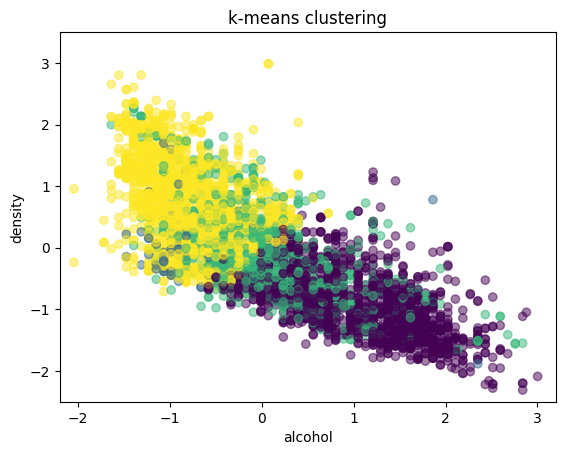

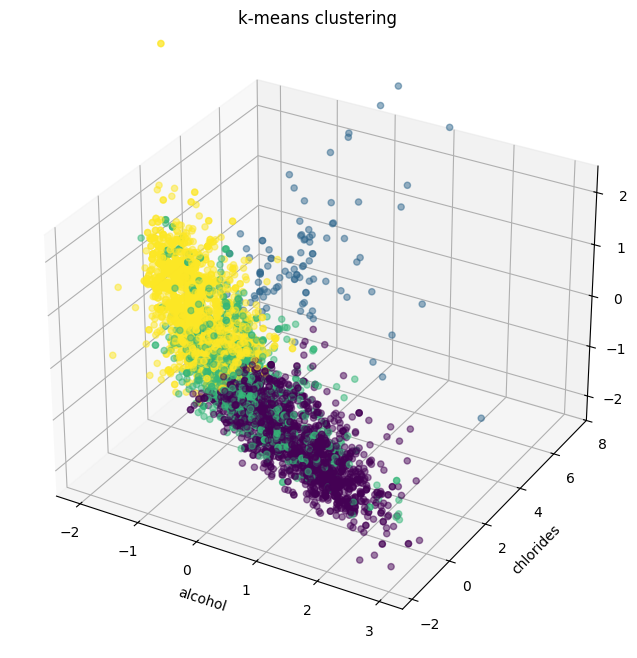

In [6]:
# For plotting
xl, yl, zl = "alcohol", "chlorides", "density"
x = wines_scaled[xl]
y = wines_scaled[yl]
z = wines_scaled[zl]

clusters = km_predicted["clusters"]

plt.scatter(x, z, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.xlim(-2.2, 3.2)
plt.ylim(-2.5, 3.5)
plt.show()

# 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("k-means clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-2.5, 8)
ax.set_zlim(-2.5, 2.5)

plt.show()

## Number of clusters

Does the number of clusters affect clustering ?

Change the variable and re-run clustering to see how the groupings change.

In [ ]:
# TODO: change n_clusters above and re-run clustering

### Interpretation

What changes ? Does one choice seem better than the others ?

### Other Clustering Options

There are many algorithms for clustering data, that differ in the assumptions they make about the data, the parameters that should be optimized, and the amount of preprocessing that is performed on the data.

There's one method called [Gaussian Clustering](https://scikit-learn.org/stable/modules/mixture.html#mixture) that is similar to K-means, but it assumes that all features of our data can be modeled as [Gaussian distributions](https://en.wikipedia.org/wiki/Normal_distribution). During clustering, the algorithm tries to minimize the standard deviation of the distribution of each cluster.

Another clustering method, [Spectral Clustering](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering), automatically combines and removes a few of our features, before doing K-means clustering. This should always be as good as, or better than, regular K-means clustering.

[Scikit-Learn](https://scikit-learn.org/) has implementations for these two clustering algorithms, and many more. They are called `GaussianClustering` and `SpectralClustering`, and their constructors take the same parameters as the `KMeansClustering` constructor.

Repeat steps $5$ and $6$ to create a model using `SpectralClustering` and run it on our data.

In [7]:
## 5. Create Clustering object
sc_model = SpectralClustering(n_clusters=n_clusters)

# TODO: Run the model
sm_predicted = sc_model.fit_predict(features)

## 6. Run the model on the training data

### Plot results

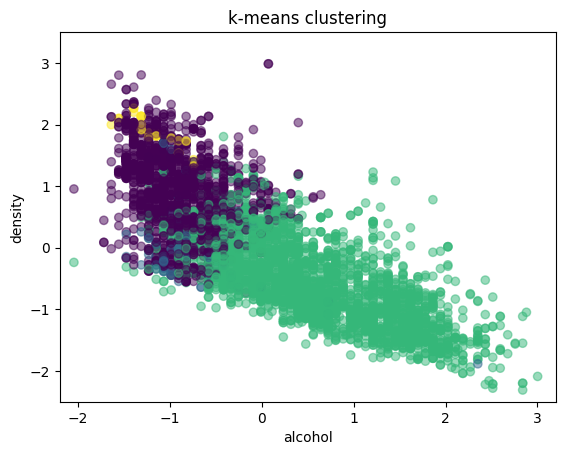

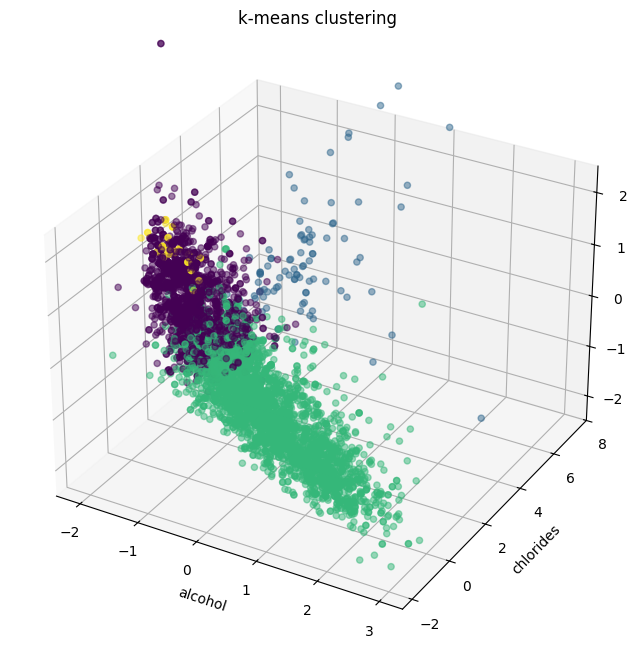

In [8]:
# TODO: plot Spectral Clustering results
# For plotting
xl, yl, zl = "alcohol", "chlorides", "density"
x = wines_scaled[xl]
y = wines_scaled[yl]
z = wines_scaled[zl]

clusters = sm_predicted["clusters"]

plt.scatter(x, z, c=clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.xlim(-2.2, 3.2)
plt.ylim(-2.5, 3.5)
plt.show()

# 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=clusters, marker='o', linestyle='', alpha=0.5)

ax.set_title("k-means clustering")
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-2.5, 8)
ax.set_zlim(-2.5, 2.5)

plt.show()

### Interpretation

Are the results any different than k-mean clustering ?

### Scoring

Would be nice to have a way to measure how good these clusters actually are.

It would help determine if we need more clusters, or if one method is actually better than the other.

There are a couple of ways to do this. We'll look at three of them.

### Distance

The first kind of scoring uses the sum of the distances between each point and its cluster's center as a metric.

Each cluster's center is represented by the average values of all of the features of all of its members: $(\overline{F_0}, \overline{F_1}, \overline{F_2}, ...)$. Once we know that we can use the L2-distance we saw above to calculate and accumulate the distances from each point to its cluster's center.

A smaller cluster distance means that the cluster center is a good representation of its members.

Luckily, our clustering models have a `distance_error()` function that can be used to report the distance error, after `fit()` has been called.

In [ ]:
print("KMeans distance error:", km_model.distance_error())
print("Spectral distance error:", sc_model.distance_error())

### Likelihood

The second way of scoring clusters treats each cluster as a potential normal distribution, and then calculates the likelihood that each point came from its cluster distribution.

Values closer to zero mean that the clusters' statistical properties (mean, variation) are good estimators for the data.

Our model objects also have a `likelihood_error()` function we can use:

In [ ]:
print("KMeans likelihood error:", km_model.likelihood_error())
print("Spectral likelihood error:", sc_model.likelihood_error())

Although somewhat related, the `distance` and `likelihood` calculations measure different things, and are in different units.

We can't compare distances to likelihoods to draw any kind of conclusion.

What we want to do is use either one of these metrics to select a clustering method and tune its parameters.

### Balance

A final metric we can consider when analyzing different clustering algorithms and strategies is to see how balanced the resulting clusters are. This isn't always important; we might have categories of items or events that are more common than others, and will produce unequal cluster groups.

In other cases, where we know we want to have groups of similar sizes, this is a good metric to look at. For example, if we were to use the body measurement dataset for deciding how many sizes of bike helmets to produce, we should probably have sizes that cover similar portions of the population, and avoid very bespoke sizes that only fit few people.

We compute `balance error` by summing the differences between our cluster sizes and the sizes of a perfectly balanced clustering. Once we have this sum, we scale it to get a number between $0$, for a perfectly balanced clustering, and $1$, for a most-unbalanced clustering.

$\displaystyle balance\ error = \frac{1}{2} \left(\frac{n}{n-1}\right) \sum_{i=1}^{n}{\left|\frac{C_i}{C_0 + C_1 + ... + C_n} - \frac{1}{n}\right|}$

The $\frac{C_i}{C_0 + C_1 + ... + C_n}$ terms are the sizes of our $n$ clusters expressed as the percentage of the total number of items in all clusters. The $\frac{1}{n}$ term is the size of each cluster in a perfectly balanced clustering. We sum up these differences and scale it all by $\frac{1}{2} \left(\frac{n}{n-1}\right)$ to get a number between $0$ and $1$.

We don't have to focus too much on this math right now. It's here for completeness and because it's good to practice reading an algorithm described as text, math equations and code.

### Balance Error

Luckily this has also been implemented for us and we can get our model's `balance error` by calling the `balance_error()` function of our clustering object:

In [ ]:
print("KMeans balance error:", km_model.balance_error())
print("Spectral balance error:", sc_model.balance_error())

### Number of clusters

If we consider the $3$ metrics for the $3$ methods, it seems like the `Spectral Clustering` algorithm performs a little bit better, even though it doesn't produce the most balanced clusters.

Once we have chosen a method, we can tune its parameters to see if we can find a combination that produces "better" clusters.

Since the only parameters our model has is the number of clusters, let's try different cluster numbers to see if there's a *better* way of clustering our wines:

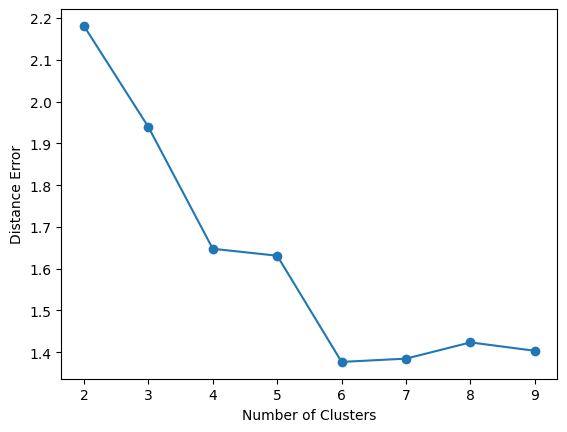

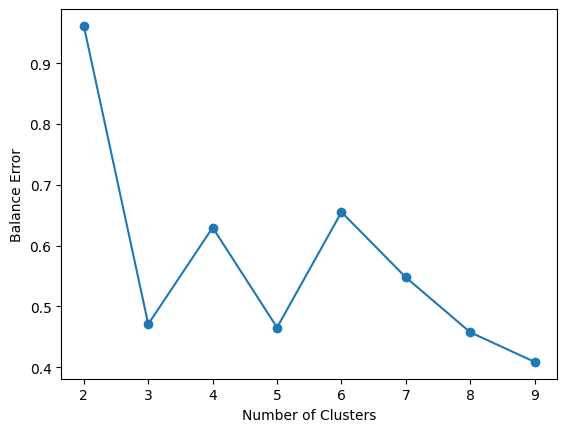

In [9]:
# try 2 - 10 clusters
num_clusters = list(range(2,10))

# collect distance, likelihood and balance errors
dist_err = []
like_err = []
bala_err = []

# get distance, likelihood and balance for different clustering sizes
for n in num_clusters:
  mm = SpectralClustering(n_clusters=n)
  mm.fit_predict(features)
  dist_err.append(mm.distance_error())
  #like_err.append(mm.likelihood_error())
  bala_err.append(mm.balance_error())

# plot errors as function of number of clusters
plt.plot(num_clusters, dist_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Error")
plt.show()

#plt.plot(num_clusters, like_err, marker='o')
#plt.xlabel("Number of Clusters")
#plt.ylabel("Likelihood Error")
#plt.show()

plt.plot(num_clusters, bala_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Error")
plt.show()

### Interpretation

Looks like $6$ could be a good number of clusters for this model, since adding additional clusters doesn't seem to make the errors go down that much.

Let's look at our data and how it got clustered:

In [ ]:
predicted = {}

n = 6
m_model = SpectralClustering(n_clusters=n)
predicted = m_model.fit_predict(features)

# For plotting
xl, yl, zl = "alcohol", "chlorides", "density"
x = wines_scaled[xl]
y = wines_scaled[yl]
z = wines_scaled[zl]

plt.scatter(x, z, c=predicted["clusters"], marker='o', linestyle='', alpha=0.5)
plt.title("Spectral Clustering n = %s" % n)
plt.xlabel(xl)
plt.ylabel(zl)
plt.xlim(-2.2, 3.2)
plt.ylim(-2.5, 3.5)
plt.show()

# 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=predicted, marker='o', linestyle='', alpha=0.5)
plt.title("Spectral Clustering n = %s" % n)
ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)
ax.set_ylim(-2.5, 8)
ax.set_zlim(-2.5, 2.5)
plt.show()

### Analysis

So, even though $6$ gives us the smallest error values, some of the clusters are really small and hard to find on the graphs.

And the cluster sizes are really unequal.

If this clustering is to be used for recommending wines to costumers, maybe using  $3$ or $4$ clusters is a more sensible way of grouping our wines. Not because we have to balance the cluster sizes, but because the subtleties of having $6$ categories of wine might be less easy to explain.

Using $4$ categories is probably more legible. The categories could be something like: `strong` for the more alcoholic wines, `bold` and `dense` for the ones that are less alcoholic, but have high density, and `wild` for the ones high in chlorides.

## Images

Clustering can also be used to help analyze image and audio files.

We can extract color information from an image by clustering its pixels by their RGB values. This can be used to get an estimate of the most "important" colors in an image. They're not the most common colors, necessarily, but the colors necessary to represent the image.

This is called `color quantization` and is a kind of compression because we reduce the total number of colors in an image from a possible $16\text{,}581\text{,}375$ unique colors to $4$, $8$, $16$, etc... colors while preserving the overall appearance of the image. The calculated cluster centers become the color palette of the image, and we can re-color the image using only those colors.

We start by loading an image:

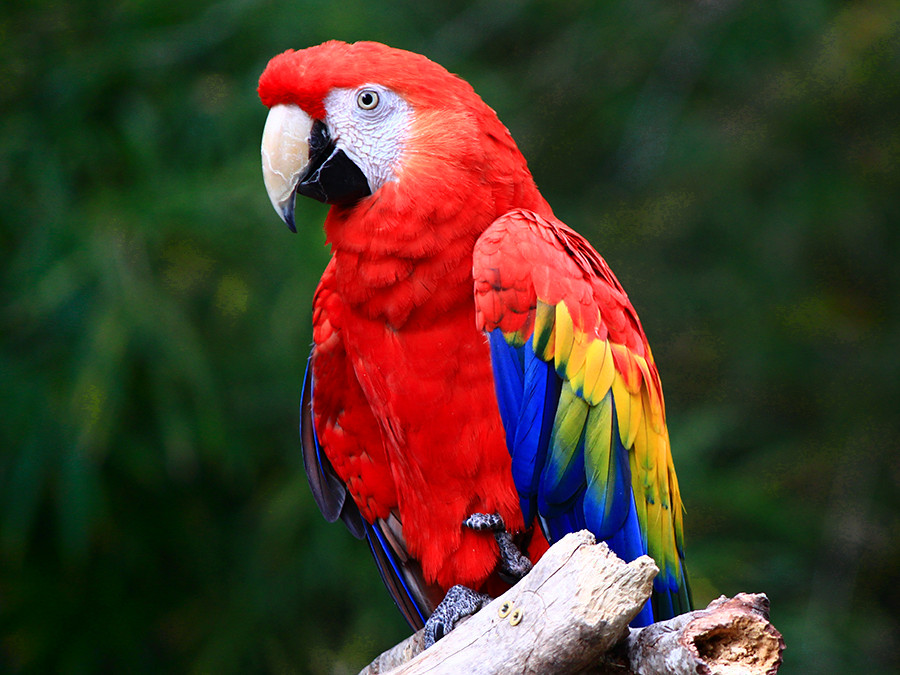

In [10]:
mimg = open_image("./data/imgs/arara.jpg")

display(mimg)

### Colors as features

Since this process works on the pixels of a single image, we can think of each pixel as a measurement and its `R`, `G` and `B` values as its features.

Before we put our image through clustering we should turn it into a `DataFrame` where the rows are the pixels and the columns are the `R`, `G`, `B` values.

We can use the `pd.DataFrame.from_records()` function, but first we have to turn our pixel list into a list of objects:

`[ [R,G,B], [R,G,B], [R,G,B], ... ]` -> `[{"R": R, "G": G, "B": B}, {"R": R, "G": G, "B": B}, ...]`

In [12]:
# TODO: create list of objects from list of lists
pixelObj = [{"R": r, "G": g, "B": b} for r, g, b, in mimg.pixels]

img_df = pd.DataFrame.from_records(pixelObj)

img_df.head()

,R,G,B
0,12,37,8
1,11,38,7
2,9,39,5
3,8,40,3
4,8,38,2


### Encoding/Scaling

Not needed! All our features are already numbers, and they're all in the same units.

### Plot

We just opened a new "dataset"... let's plot it.

Since our features are the `R`, `G` and `B` channel values for each pixel, we can actually plot these in $3D$.

Each of the features will place a point in `x`, `y`, `z` space, and the color of the point can be the color of the pixel.

The only funny business here is that `pyplot` expects colors in the range $[0, 1]$ and not $[0, 255]$, so we have to convert those.

We could use a `MinMaxScaler`, but since the inputs are already in a known range and the math is easy, we'll just use a comprehension.

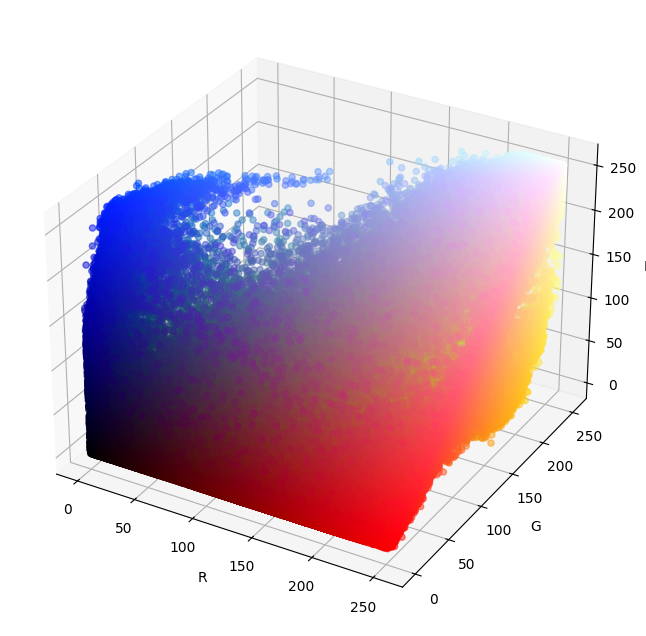

In [13]:
# convert [0, 255] to [0, 1]
c = [(r/255, g/255, b/255) for r,g,b in mimg.pixels]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(img_df["R"], img_df["G"], img_df["B"], c=c, marker='o', linestyle='', alpha=0.5)
ax.set_xlabel("R")
ax.set_ylabel("G")
ax.set_zlabel("B")
plt.show()

### Cluster !

Set up the `Clustering` object and run `fit_predtict()`.

In [20]:
n_clusters=8

## Create Clustering object
km_model = KMeansClustering(n_clusters=n_clusters)

## Run the model on the pixel data
km_predicted = km_model.fit_predict(img_df)

km_predicted.head()

,clusters
0,6
1,6
2,6
3,6
4,6


### Un-cluster

The `km_predicted` variable holds a `DataFrame` that is a mapping from pixel index to cluster index, but what we really want is to re-map our original pixels into the color palette made up of our cluster centers.

The `KMeansClustering` object has a member variable called `cluster_centers_` that holds the centers of our clusters. We can use this to build a new pixel array for our image.

Let's take a look at the cluster centers:

In [21]:
km_model.cluster_centers_

[[165.01918672323808, 6.534825216836256, 5.228626140502384],
 [10.863379814077025, 36.49269588313413, 168.9909528552457],
 [36.53286531166846, 59.70232501085131, 33.99520183434298],
 [226.25113165042004, 22.039560393287996, 20.754489757247825],
 [230.3209868569768, 219.6249233054542, 227.55685084121808],
 [246.62947551470359, 123.73483836909605, 81.93208707263298],
 [16.60188508895509, 36.491004174063235, 16.527755121623567],
 [136.36187437215625, 125.9718725994209, 93.94811794599066]]

We have $4$ lists inside the `cluster_centers_` list. They should represent colors, but they're using floating point numbers right now, which will most likely give us troubles when we try to turn these into an image.

Let's transform these into `int`s:

In [22]:
# TODO: use round() or int() to ensure our cluster centers are valid color values (ints)
color_centers = [[round(r), round(g), round(b)] for r, g, b, in km_model.cluster_centers_]

print(color_centers)

[[165, 7, 5], [11, 36, 169], [37, 60, 34], [226, 22, 21], [230, 220, 228], [247, 124, 82], [17, 36, 17], [136, 126, 94]]


Now we can use these in a pixel array.

Let's iterate through the `km_predicted["clusters"]` and use those values to push their corresponding cluster center colors into a new pixel array.

We go through `km_predicted["clusters"]`, and if we see cluster $0$ we want to push `color_centers[0]` onto our pixel array, etc...

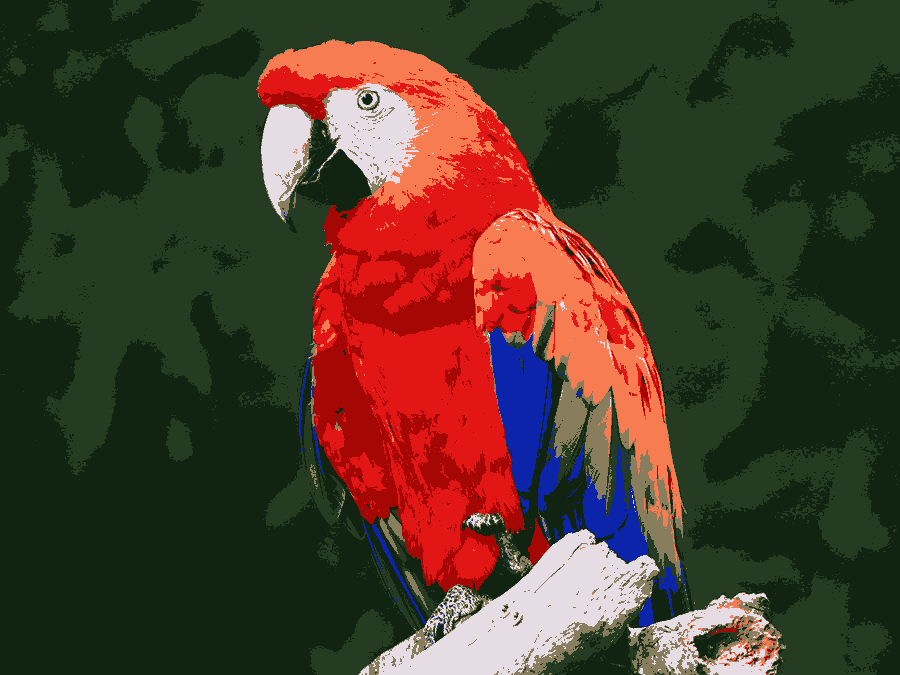

In [23]:
clustered_pxs = []

# TODO: iterate through the cluster list and append the right color for each pixel
for g in km_predicted["clusters"]:
    clustered_pxs.append(color_centers[g])


display(make_image(clustered_pxs, mimg.size[0]))

## Audio (Optional)

We can also use clustering to help analyze audio files after we've run an `FFT` analysis.

**Review**: The `FFT` analysis tell us which audio frequencies are present in our file. The function returns $2$ lists, one of frequencies present, and another of how much energy is present in each of those frequencies. Higher energy for a frequency means that frequency is more dominant in the sound.

We would like to use the `FFT` as a way to extract a reduced, but meaningful, set of features from our audio files to use in some kind of classification model.

Let's open up an audio, plot it, play it, run `FFT` and look at the results.

In [ ]:
# Open up audio file
sound_file_path = "./data/sounds/piano-8.wav"
my_samples = wav_to_list(sound_file_path)

# Plot it
plt.plot(my_samples)
plt.show()

# Play it
display(Audio(sound_file_path))

# FFT it
fft_energy, fft_freqs = fft(my_samples)

print("num samples:", len(my_samples))
print("num frequencies:", len(fft_freqs))

# 🤔

For an audio file with $80\text{,}000$ samples, our `FFT` returns two lists of $40\text{,}000$ values, so not really a reduction in features.

### Plot FFT
Let's plot the result of the `fft()` command and see how to bring this number down to something more legible and meaningful.

In [ ]:
# Plot FFT
plt.plot(fft_freqs, fft_energy, "o", markersize=2)
plt.show()

# 🤔

Only a portion of the frequencies seem to have any kind of signal.

If we zoom into the parts with energy, we can see that we have some dominant frequencies, but determining what they are automatically can be kind of messy.

In [ ]:
# Plot FFT
plt.plot(fft_freqs, fft_energy, "o", markersize=2)
plt.xlim([0, 15000])
plt.ylim([0, 100000])
plt.show()

### Filter

Let's filter out the frequencies with low energy and round the frequency values to whole numbers.

In [ ]:
fft_energy_f = []
fft_freqs_f = []

E_THRESHOLD = 2e3

for e, f in zip(fft_energy, fft_freqs):
  if e > E_THRESHOLD:
    fft_energy_f.append(e)
    fft_freqs_f.append(round(f))

# Re-plot FFT
plt.plot(fft_freqs_f, fft_energy_f, "o", markersize=2)
plt.show()

### Cluster Prep

This looks better and we can try to cluster these by frequency to get a better understanding of the dominant frequencies of the audio.

Let's first put the frequency and energy into a `DataFrame`:

In [ ]:
fft_f_df = pd.DataFrame({ "frequency": fft_freqs_f, "energy": fft_energy_f })

display(fft_f_df.head())

### Cluster by Frequency

Let's find clusters for the filtered frequency values.

The number of clusters is something that can be adjusted if we feel the need. It will determine how many features we end up with in our transformed dataset.

In [ ]:
n_clusters=16

# Create Clustering object
km_freq_model = KMeansClustering(n_clusters=n_clusters)

# Run the model on the fft frequency data
km_freq_predicted = km_freq_model.fit_predict(fft_f_df[["frequency"]])

print(km_freq_model.cluster_centers_)

### Plot Clusters

Plot the filtered frequencies and the cluster centers on the same graph:

In [ ]:
# Plot FFT and cluster centers
plt.plot(fft_f_df[["frequency"]], fft_f_df[["energy"]], "o", markersize=2)
for f in km_freq_model.cluster_centers_:
  plt.scatter(f[0], f[-1], c='red', s=20)
plt.show()

### Refine

We have reduced the number of features of our audio file from $80\text{k}$ to $16$, which is great, but some of those $16$ frequencies might not actually be very representative of the audio because they represent frequencies with pretty low energies.

What if we included both `frequency` and `energy` in our clustering?

We don't even have to filter the original lists from the `fft()` command because we could do filtering later.

In [ ]:
# FFT of our samples
fft_energy, fft_freqs = fft(my_samples)

# put raw fft results in DataFrame this time
fft_df = pd.DataFrame({"frequency": fft_freqs, "energy": fft_energy})

# TODO: repeat clustering, but using both columns of our DataFrame

# Create Clustering object

# Run the model on the fft data

# print cluster centers

# Plot FFT and cluster centers

### Interpretation

Some of the clusters are still centered on frequencies with low energy, but because our cluster centers now have $2$ values we can tell how much energy each of these cluster centers represent and we can sort the cluster centers by their energy to get a final feature set.

Even if we don't do this sorting, we now have $16$ clusters, each with $2$ values, so a total of $32$ features that could be used to classify each audio file.

## More Unsupervised Learning

### Dimensionality Reduction

A few homeworks ago we looked at an image classification exercise and we saw that creating image filters by hand and selecting which features to look at can be a very laborious and complex process. Let's now combine what we learned about data normalization, distances, and learning algorithms to try to create a better image classification system.

Consider the following image that is $4$ pixels wide by $4$ pixels high, it has a total of $16$ pixels:

<img src="./imgs/pixdim-00.jpg" height="200px" />

We can think of these $16$ pixels as the features of the image, and if we had a dataset of images of this size, we can think of the rows in this dataset as our different images and then the columns being the $16$ values for each of the pixels of those images.

And the same is true for a dataset that has images that are $256$ by $256$ pixels:

<img src="./imgs/pixdim-01.jpg" height="200px" />

We would just have as many rows as we have images, and each of those rows would have $65,536$ columns/features, one for each of its pixels.

We might be tempted now to develop some kind of method that uses $L2$ distances or cosine similarities to classify images by finding similarities between their pixel content. And that might work sometimes, but consider that computing the $L2$ distance between $2$ of our $256$ x $256$ pixel images would require squaring over $65000$ terms... and if we look at the black and white $4$ x $4$ images below, it's not so clear that subtracting raw pixel values would give us any indication of similarity:

<img src="./imgs/pixdiff.jpg" height="200px" />

The difference between the first image and the second image is of $8$ pixels. The difference between the first and third image is also of $8$ pixels, while the difference between the second and third image is of $16$ pixels, even though they're more similar. The same could be calculated for the last two pictures and the first.

What we want to do instead is something called **_dimensionality reduction_**, where we turn those $65,000$ columns of pixel values into a smaller number of columns that represent more meaningful and complex information about the images.

### Projection

One way of reducing the dimensions of our dataset is by doing something called **_feature projection_**, which is very simple to perform and understand. We did this when we dropped features from the wine dataset last week.

**_Feature Projection_** is when we just drop the columns in our dataset that we think are less important. The results of doing this can be seen in the following two images:

<img src="./imgs/dimredproj-00.jpg" height="350px" />

On the left side we have a graph of our data set in two dimensions. On the right, at the very bottom, we've projected all of those points straight down onto the x-axis by just ignoring their $y$ components.

On next image we can see what the problem with doing that might be. Points that are actually further apart in our full dataset will seem closer once projected to a lower dimension like this, and points that are close together in $2D$ space can seem further apart in $1D$ space.

<img src="./imgs/dimredproj-03.jpg" height="350px" />

### Space-Filling Curves

Another way of reducing dimensions is by using **_space-filling curves_**, like the [Hilbert curve](https://en.wikipedia.org/wiki/Hilbert_curve) or [Z-order curves](https://en.wikipedia.org/wiki/Z-order_curve).

These functions reorder our data by tracing a curvy path between all the points in our dataset. If we look at the following images:

<img src="./imgs/dimredcurve-00.jpg" height="350px" />

The image on the left again shows our $2D$ data points graphed on a plane. On the right, we've drawn a line that connects all of our points by starting with a point on the lower-left side of the graph and then connecting to the nearest point, and then the next nearest point and so on and so on. In the end we have the light-blue line that connects and re-orders all of our $2D$ points into a $1D$ line.

The problem with this method is that **_space-filling curves_** still have some discontinuities, or jumps, which might result in the same problem as **_projection_**, where closer points become further apart after transformation and vice-versa.

### Principal Component Analysis

One final way of reducing the dimensions in our dataset is by doing something called **_principal component analysis_** or **_PCA_**. This is a kind of unsupervised learning algorithm that looks at all of our original data and tries to figure out the directions in which it spreads out the most.

<img src="./imgs/dimredpca-00.jpg" height="350px" />

Again, on the left we have the original $2D$ data on a plane. On the right we see the original data with a line that represents the direction in which the data seems to spread.

**_PCA_** is kind of, sort of, like doing **_Linear Regression_** in a special manner, and finding many lines-of-best-fit, but with special properties. We can think of these new lines as new axes that we re-orient our data around, and instead of having the $x$ axis and the $y$ axis we'll have $2$ new axes, one in the direction that captures the most variation in our data, and another in a perpendicular direction, that captures less of the variation in our data, like below:

<img src="./imgs/dimredpca-03.jpg" height="350px" />

But, wait ! If we have $N$ dimensions to begin with and we end up with these $N$ lines/axis/features, isn't it the same as before ? We still have $N$ dimensions to deal with!

Yes, but the thing about the **_PCA_** axes is that these lines, or, principal components, are actually ordered by importance, so the very first principal component is the one that captures most of the variation in our data, the second one captures the second most amount of variation in our data, the third one the third most, and so on and so on...

What we want to do after we compute the principal components of our dataset is perform a **_projection_** and chop off most of the new dimensions. Most of the information about our data will be captured by the first couple of principal components, so we can now project our data onto a few of these new axes and they'll retain most of the information about our data.

<img src="./imgs/dimredpca-02.jpg" height="350px" />

In the $2D$ case above if we only consider the first principal component and project our data onto that blue line we retain most of the information about the relative distances between the points in our dataset, but since they're all projected onto a line, they can be represented by just $1$ feature/value. In the end we were able to reduce our data from having $2$ variables in the $XY$ plane to just having one variable in the direction of the first principal component.

Let's look at some examples.

#### PCA in 3D

Let's reload the `ANSUR` data and look at only the features about hands. We'll use PCA to reduce the dimensions of this subset of our data from $3$ to $1$ dimension.

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


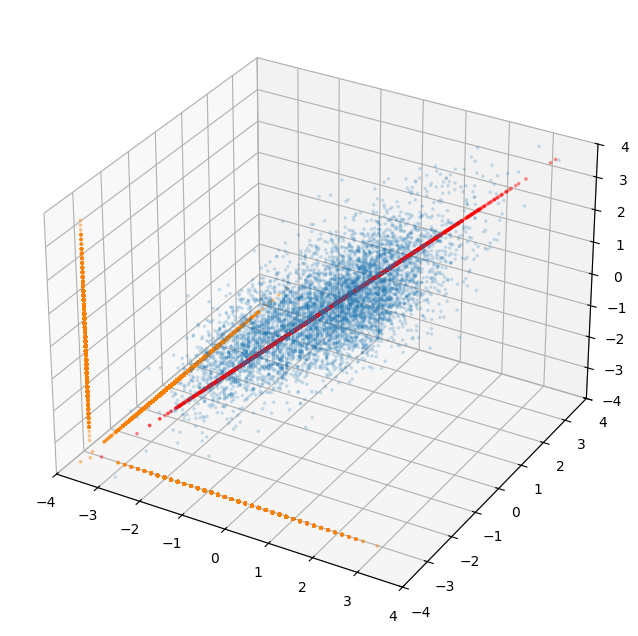

In [24]:
ANSUR_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

ansur_df = pd.json_normalize(ansur_data)
display(ansur_df.head())

hand_df = ansur_df[["hand.breadth", "hand.length", "hand.palm"]]

# scale and pca objects
hand_mss = StandardScaler()
hand_pca = PCA(n_components=1)

# perform scaling and pca
hand_df = hand_mss.fit_transform(hand_df)
hand_pca_df = hand_pca.fit_transform(hand_df)

# project from 1 PCA back to original 3 dimensions
hand_pca_i_df = hand_pca.inverse_transform(hand_pca_df)

# plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(hand_df["hand.breadth"], hand_df["hand.length"], hand_df["hand.palm"], s=3, alpha=0.15)
ax.scatter(hand_df["hand.breadth"], [-3.5]*len(hand_df["hand.length"]), [-3.5]*len(hand_df["hand.palm"]), s=3, c='#ff8000', alpha=0.333)
ax.scatter([-3.5]*len(hand_df["hand.breadth"]), hand_df["hand.length"], [-3.5]*len(hand_df["hand.palm"]), s=3, c='#ff8000', alpha=0.333)
ax.scatter([-3.5]*len(hand_df["hand.breadth"]), [-3.5]*len(ansur_df["hand.length"]), hand_df["hand.palm"], s=3, c='#ff8000', alpha=0.333)
ax.scatter(hand_pca_i_df["hand.breadth"], hand_pca_i_df["hand.length"], hand_pca_i_df["hand.palm"], s=3, c='r', alpha=0.333)
ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))
ax.set_zlim((-4, 4))
plt.show()

The graph above shows the original data for the `hand.breadth`, `hand.length` and `hand.palm` features in blue.

The orange points show the data projected onto the different axis. It is $1$ dimensional, meaning that in each of those cases we've completely ignored two features.

The red points show our data projected onto the first principal component.

If we call the `pca.explained_variance()` function we can see how much of our data's information has been retained.

In [25]:
hand_pca.explained_variance()

np.float64(0.8269191398484806)

#### PCA in all dimensions

What if we reduce all of our features to just $1$? How much of the data's information is kept?

If we want to keep $80\%$ of our data's variance, how many components should our PCA use?

No need to plot anything, just run pca a few times and look at its `explained_variance`.

In [26]:
## Repeat above process, using all of the original features, except gender
mss = StandardScaler()
ansur_df = pd.json_normalize(ansur_data).drop(columns=["gender"])
ansur_df = mss.fit_transform(ansur_df)

## TODO: get explained_variance() for n_components=1

## TODO: find n_components for explained_variance >= 0.80


### Interpretation

It takes more than $3$ components to keep $80\%$ of the information from our data. This isn't something we can easily plot to compare to the distribution of the original $14$ features.

We can plot the first $2$ and first $3$ principle components, but after that we just have to trust the `explained_variance` number.

#### More PCA in Multiple Dimensions

The above exercises are good for us to start building intuition about PCA, but even though we can perform PCA and reduce our features from $15$ to $5$ or $6$ principal components while retaining most of the variation in our data, it gets hard to visualize the effects of these transformations.

Let's use images. We'll load images with about $10,000$ pixels/features, and perform PCA to represent them using only $10$ components. Then we'll remap our $10$ components for each image back to $10,000$ pixels to look at the effects of **_compressing_** our data like this.

#### PCA on Images

Let's load all of the images inside the `data/imgs/att-faces/` directory. These images are in sub-directories that specify the `id` of the person in the image: `s0` is `subject 0`, `s1` is `subject 1`, and so on.

We'll keep track of these ids and create numeric labels for them as we read the data from the images.

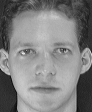

400 400
40
10304 [48, 49, 45, 47, 49, 57, 39, 42, 53, 49]


In [27]:
# lists for keeping track of image pixel lists, subject numeric id and subject label
face_pixels = []
face_ids = []
id2label = []

# 40 directories
for l in range(1, 41):
  id2label.append(f"s{l}")
  # 10 images per directory
  for i in range(1, 11):
    mimg = open_image(f"./data/imgs/att-faces/s{l}/{i}.pgm")
    face_pixels.append(mimg.pixels)
    face_ids.append(l)

# display first image
display(make_image(face_pixels[0], width=92))

# print len of lists to make sure sizes match
print(len(face_pixels), len(face_ids))

# check number of labels matches number of directories
print(len(id2label))

# check how many pixels per image and look at first 10 pixel values
print(len(face_pixels[0]), face_pixels[0][:10])

These look ok.

#### Run PCA

We can run PCA directly on these lists of pixels. We don't even have to scale the data because we know the pixel values are all between $0$ and $255$ for greyscale images.

In [31]:
# run pca and get first 10 PCs
pca = PCA(n_components=10)
faces_df = pca.fit_transform(face_pixels)

# put id values in DataFrame
faces_df["id"] = face_ids

display(faces_df.head())

print(pca.explained_variance())

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,id
0,1531.176049,1072.181267,-1867.025752,261.784157,689.919485,-123.792298,424.204352,-377.590182,-439.564567,-1032.182593,1
1,2975.896454,759.883085,461.811664,1206.322337,2506.667235,384.234240,1229.992765,324.484781,-385.872178,73.071286,1
2,2696.449220,380.515753,-1004.961838,-31.708422,1029.603798,-1081.150995,463.232415,237.550347,-1116.635890,-822.060826,1
3,3242.390090,1162.888290,225.102686,2717.875557,-21.034545,-820.925372,-678.282466,-963.479260,485.812009,-886.887176,1
4,3644.615759,808.845852,-116.302230,2126.586853,214.951673,-461.790027,535.782794,206.397603,106.553467,-114.212211,1


0.5995186134824272


#### Interpretation

Our PCA-transformed data retained about $60\%$ of the information from the original data.

Our `DataFrame` now is expressed in terms of the first $10$ principal components of our data. The values for these new features are all over the place, and don't represent pixel colors anymore. They represent our data in a more _abstract_, _latent_ space. It's latent because the information is there, it exists, but it's sort of waiting to be transformed back into physical values and, in this case, visualized as pixels.

This `PCA` transformation was able to compress our data and reduce the number of dimensions for each of our images from $10304$ to $10$ ! That's a reduction factor of $1000$ ! We could start thinking about doing clustering or classification by measuring distances between these images because now they only have $10$ dimensions, and each of the dimensions represents a combination of color information, not just one pixel.

But, let's visualize our new compressed images first.

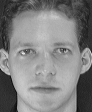

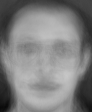

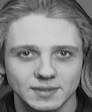

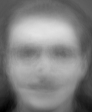

In [32]:
# Reconstruction: un-projects the data from PCA space into pixel space
pca_pixels = pca.inverse_transform(faces_df)

display(make_image(face_pixels[0], width=92))
display(make_image(pca_pixels.loc[0], width=92))

display(make_image(face_pixels[110], width=92))
display(make_image(pca_pixels.loc[110], width=92))

### 🤔

We did lose $40\%$ of the detail of our data when we transformed it into `PCA` space.

These don't look too good at first, but they also don't look that bad. Given how regular all of the images are, maybe this level of detail is all that is needed to do any kind of classification or clustering.

#### More components

Re-run PCA with $20$ and $120$ components. Don't worry about printing the `DataFrame`, but reconstruct some of the images like we did in the cell above.

What is the effect of keeping more components in our PCA?

In [ ]:
## TODO: reconstruct images using 20 and 120 component PCAs

## No need to re-write the code here, we can just change the parameters and re-run the cells above

### Common features

One way to think about how `PCA` compresses our features, is to image that it can factor out common elements between features that are strongly correlated. For numerical data, those common factors are just parameters to a series of multiplications. Boring.

With images, the common factors between our features can actually be seen because our features represent pixels.

We can iterate over the `PCA` factors (or, `components`) and display them as images. We just have to scale them to pixel range.

In [ ]:
for comp in pca.components_[:5]:
  minVal = comp.min()
  maxVal = comp.max()
  # manually mapping to [0, 1]
  pxs01 = (comp - minVal) / (maxVal - minVal)
  # mapping to [0, 255]
  pxs = [255 * p for p in pxs01]
  display(make_image(pxs, width=92))

### Interpretation

Having $10$ components in our transformation means having $10$ of these "common" faces and $10$ features in our transformed dataset. The original faces are reconstructed (with error) by multiplying the $10$ features in the transformed dataset by their corresponding face, so `PC0` with the first face, `PC1` with the second face, and so on, and then adding those results.

These top-5 "common" faces will always be the same for this dataset, independent of the number of components we keep in our `PCA` transformation. 

Adding components to our transformation just increases the number of these "common" faces that get extracted, but their order doesn't change.

#### Back to $10$ components

Let's go back to just using $10$ PCs and see how the first $100$ images are distributed in the first $2$ dimensions.

In [ ]:
# run pca and get first 10 PCs
pca = PCA(n_components=10)
faces_df = pca.fit_transform(face_pixels)

# put id values in DataFrame
faces_df["id"] = face_ids

# first 10 ids
x = faces_df["PC0"][:100]
y = faces_df["PC1"][:100]
c = faces_df["id"][:100]

plt.scatter(x, y, c=c, marker='o', linestyle='', alpha=1, cmap="tab10")
plt.title("Principal Components")
plt.xlabel("PC 0")
plt.ylabel("PC 1")
plt.show()

#### Interpretation

Here are only looking at the top $2$ and $3$ dimensions of our data and we can already see some patterns/clusters.

The colors were added manually using the correct `id` for each image, so that helps to see patterns...

So, let's run the `RandomForestClassifier` algorithm on this dataset to see if PCA dimensionality reduction can actually help prepare image datasets for classification tasks.

### PCA + Classification

We have already prepared our `DataFrame` and added a column with the numerical `id` of each image.

We can check by running `faces_df.head()`:

In [ ]:
faces_df.head()

#### Separate Train and Test Data

In order to measure how well our classifier works in general, we should separate our data into $2$ subsets, one which will get used to train our model, and another that we can use to measure how well our model performs on data it hasn't seen before.

This is to avoid having our model memorize the training data, and then performing horrible on new data in the future.

We'll use the `Scikit-Learn` function `train_test_split` to split our `DataFrame` into $2$ equal datasets.

Since the split is random, the `while` loop below is just to guarantee that our test dataset has images from all subjects.

In [ ]:
test_ids = []

while len(set(test_ids)) != len(id2label):
  faces_train_df, faces_test_df = train_test_split(faces_df, test_size=0.5)
  test_ids = faces_test_df["id"]

#### Train Classifier

The below steps should look familiar.

We split the output feature from he rest of the features, and pass those to the `fit()` function of an instance of the `RandomForestClassifier` class.

We're not re-scaling our components/features from `PCA`, because we're assuming that any difference in the magnitude of those features is actually important information that the algorithm can use to create a model. And, `RandomForest` and `DecisionTree` classifiers tend to be a little less sensitive to scaling because of their `if`/`else` nature.

That's not always the case. Our modeling process might benefit from having standardized data to work with.

In [ ]:
face_model = RandomForestClassifier()

train_features = faces_train_df.drop(columns=["id"])
train_ids = faces_train_df["id"]

# Create a model that classifies faces based on principal components
face_model.fit(train_features, train_ids)

## 6. Run the model on the training data
train_predicted = face_model.predict(train_features)

## 7. Measure error
classification_error(train_ids, train_predicted)

Classification Error should be close to $0$.

#### Test Data

Now we'll run the `predict()` function of our classifier on our test dataset and see how it performs.

Again, this should look familiar: we just have to remember to separate the output feature (`id`) from the other features, and then pass those $2$ lists to the `predict()` function.

In [ ]:
test_features = faces_test_df.drop(columns=["id"])
test_ids = faces_test_df["id"]

## 6. Run the model on the test data
test_predicted = face_model.predict(test_features)

## 7. Measure error
classification_error(test_ids, test_predicted)

#### Interpretation

The Classification Error should be around $20\%$. This isn't bad !

Remember, we just loaded up some unknown dataset of images, automatically reduced the number of dimensions in each image from $10304$ to $10$ and used a basic `RandomForestClassifier()` to learn patterns on the compressed data.

We didn't have to look at pixels, we didn't have to manually filter images, we didn't even have to guess which features to keep. PCA helped with all of this.

#### Confusion Matrix

We can run the following cell to print a **_Confusion Matrix_** for our model. This is a graph that shows how well our model performed on each class of our data.

In [ ]:
display_confusion_matrix(test_ids, test_predicted, display_labels=id2label)
plt.show()

There's probably a class or two that our model didn't do too well with.

#### Improving Our Model

How can we improve this model ? We picked $10$ components just to see what would happens with a dimensionality reduction of $1000$.

What happens if we use $100$ components? $100$ is still a lot less than $10304$ and probably still easy for our `RandomForestClassifier` to handle.

How much of the data's variance is kept with $100$ components?

In order to improve the classifier it might not be enough to just increase the number of components, but also adjust the train/test split. In order for the model to really learn more complex pattern we should give it a bit more data to train on.

Maybe decreasing the `test_size` parameter in the `train_test_split()` function to $0.3$ or $0.25$ will help the model learn from the extra information in the $100$ components.

In [ ]:
## TODO: Re-run the classification training, but using 100 PCs

### Conclusion

Unsupervised learning can be a very powerful and useful tool for performing exploratory data analysis and data pre-processing.

Because there's no labeled/correct answer in unsupervised learning, we can be a bit more subjective in how we pick our metrics for success.